# Time series clustering exercise

# Data

Download the census bureau business data for all years 1993-2014. You can investigate using the API (I have not done it with the census bureau). I did is as you see below

In [1]:
!ls $PUIDATA/

201401-citibike-tripdata.csv
201401-citibike-tripdata.zip
201501-citibike-tripdata.csv
201501-citibike-tripdata.zip
201502-citibike-tripdata.csv
201502-citibike-tripdata.zip
201503-citibike-tripdata.csv
201503-citibike-tripdata.zip
201504-citibike-tripdata.csv
201504-citibike-tripdata.zip
201505-citibike-tripdata.csv
201505-citibike-tripdata.zip
201506-citibike-tripdata.csv
201506-citibike-tripdata.zip
201507-citibike-tripdata.csv
201507-citibike-tripdata.zip
201508-citibike-tripdata.csv
201508-citibike-tripdata.zip
201601-citibike-tripdata.csv
201601-citibike-tripdata.zip
201602-citibike-tripdata.csv
201602-citibike-tripdata.zip
201603-citibike-tripdata.csv
201603-citibike-tripdata.zip
201604-citibike-tripdata.csv
201604-citibike-tripdata.zip
201606-citibike-tripdata.csv
201606-citibike-tripdata.zip
201607-citibike-tripdata.csv
201607-citibike-tripdata.zip
201608-citibike-tripdata.csv
201608-citibike-tripdata.zip
201610-citibike-tripdata.csv
201610-citibike-tripdata.zip
201612-citibik

 Download the NYC zipcodes shapefile. One of many ways in which you can get the zipcodes shapefile for NYC
 https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip


In [2]:
!wget -nc -O $PUIDATA/nyc_zips.zip https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip
!cd $PUIDATA; unzip -o nyc_zips.zip

--2017-12-20 00:38:06--  https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip
Resolving data.cityofnewyork.us... 52.206.68.26
Connecting to data.cityofnewyork.us|52.206.68.26|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://data.cityofnewyork.us/api/views/i8iw-xf4u/files/YObIR0MbpUVA0EpQzZSq5x55FzKGM2ejSeahdvjqR20?filename=ZIP_CODE_040114.zip [following]
--2017-12-20 00:38:07--  https://data.cityofnewyork.us/api/views/i8iw-xf4u/files/YObIR0MbpUVA0EpQzZSq5x55FzKGM2ejSeahdvjqR20?filename=ZIP_CODE_040114.zip
Connecting to data.cityofnewyork.us|52.206.68.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1514401 (1.4M) [application/octet-stream]
Saving to: “/home/cusp/vmr286/PUIdata/nyc_zips.zip”

100%[======================================>] 1,514,401   1.95M/s   in 0.7s    

2017-12-20 00:38:08 (1.95 MB/s) - “/home/cusp/vmr286/PUIdata/nyc_zips.zip” saved [1514401/1514401]

Archive:  nyc_zips.zip
  inflating: ZI

## You can use zipfile module in python to unzip the files
it should be install in your system, but if it is not you can get the code with wget from here
https://github.com/python/cpython/blob/2.7/Lib/zipfile.py
remembering to use the raw link
(or you can use the usual shell commands, and miss the chance to learn something new)

In [3]:
from collections import Counter
from datetime import datetime
import glob
import os
import zipfile

import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
# this is not completely in line with pep8 
# but i make a stylistic choice 
# because notebooks
%matplotlib inline 
import numpy as np
import pandas as pd
pd.options.display.max_columns = None
from sklearn.cluster import KMeans

PUIDATA = os.environ.get("PUIDATA", "./data")

In [4]:
def process(zf, fname):
    year = fname.split("/")[-1][3:5]
    if year.startswith("0") or year.startswith("1"):
        year = "20" + year
    else:
        year = "19" + year
        
    replaced = fname.split("/")[-1].replace('.zip','.txt')
    partial = pd.read_csv(zf.open(replaced),
                          dtype={"zip": object, 
                                 "ZIP": object})
        
    if 'ZIP' in partial:
        partial['zip'] = partial['ZIP']
    if 'EST' in partial:
        partial['est'] = partial["EST"]
    partial["year"] = int(year)

    return partial

fnames = glob.glob(PUIDATA + "/zbp*.zip")
fnames
zfs = [zipfile.ZipFile(fname) for fname in fnames]
df = pd.concat(process(zf, fname) for zf, fname in zip(zfs, fnames))
df.head()

,AP,EMP,EMPFLAG,EST,NAME,QP1,ZIP,ap,ap_nf,city,cty_name,emp,emp_nf,empflag,est,name,qp1,qp1_nf,stabbr,year,zip
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,155158.0,NaN,NaN,NaN,6198.0,NaN,NaN,439,"Agawam, MA",33601.0,NaN,NaN,1994,01001
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,127367.0,NaN,NaN,NaN,6073.0,NaN,NaN,450,"Amherst, MA",28924.0,NaN,NaN,1994,01002
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1604.0,NaN,NaN,NaN,68.0,NaN,NaN,10,"Amherst, MA",367.0,NaN,NaN,1994,01003
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4302.0,NaN,NaN,NaN,210.0,NaN,NaN,47,"Amherst, MA",844.0,NaN,NaN,1994,01004
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13521.0,NaN,NaN,NaN,678.0,NaN,NaN,92,"Barre, MA",3010.0,NaN,NaN,1994,01005


In [5]:
zipcodes = gpd.read_file(PUIDATA + "/ZIP_CODE_040114.shp")
zipcodes.head()

,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry
0,11436,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,0.0,0.0,"POLYGON ((1038098.251871482 188138.3800067157,..."
1,11213,0,Brooklyn,62426.0,2.963100e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1001613.712964058 186926.4395172149,..."
2,11212,0,Brooklyn,83866.0,4.197210e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1011174.275535807 183696.33770971, 1..."
3,11225,0,Brooklyn,56527.0,2.369863e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((995908.3654508889 183617.6128015518,..."
4,11218,0,Brooklyn,72280.0,3.686880e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((991997.1134308875 176307.4958601296,..."


In [6]:
final = df.merge(zipcodes, right_on="ZIPCODE", left_on="zip").drop_duplicates(subset=["zip", "year", "est", "emp"])

# Data cleaning

you may need to clean your data: for some NYC zip codes there may be no info
sanity check: you should have 20 (N_timestamps) datapoints per time series and about 250 zipcodes (Nzipcodes)

245 zips
This looks about right. Zipcodes change over time so there 
may be messiness associated with that. Value counts below.


21    230
20      1
19      2
18      1
17      1
16      1
14      2
13      1
9       2
8       1
6       1
5       1
2       1
Name: year, dtype: int64

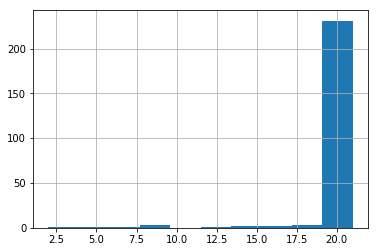

In [7]:
final.groupby("zip").count()["year"].hist()
print "{} zips".format(len(final.groupby("zip")))
print "This looks about right. Zipcodes change over time so there "
print "may be messiness associated with that. Value counts below."
final.groupby("zip").count()["year"].value_counts().sort_index(ascending=False)

In [8]:
final_filtered = final.groupby("zip").filter(lambda g: g.year.nunique() == 21)
print "{} zips with exactly 21 years".format(len(final_filtered.groupby("zip")))

230 zips with exactly 21 years


IMPORTANT: we talked about the importance of "whitening" your data.
Whitenings decorrelates the data: it makes the features independent so that the data covariance matrix is the identity matrix.
Whitening your data in time series analysis is in most cases **wrong**: you are modifying your time behaviour. This is because of the strong correlation between features (two consecutive time stamps for the same observation, the same zip code here, are strongly correlated). Here instead you want to standardize your time series: subtract the mean and divide each time series (separately) by its standard deviation. As a sanity check (if you use skitlearn Kmeans or skitlearns kmeans2): you want your data array to be shaped Nzipcodes x Ntimestamps

mydata.shape should be (Nzipcodes, Ntimestamps)

mydata[i].std() shoould be 1 for all i in range(len(Nzipcodes))

mydata[i].mean() should be ~0 for all i in range(len(Nzipcodes))

In [9]:
final_filtered[["zip", "year", "est"]].head()

,zip,year,est
0,10001,1994,6999
1,10001,1995,7088
2,10001,1996,7075
3,10001,1997,7154
4,10001,1998,7254


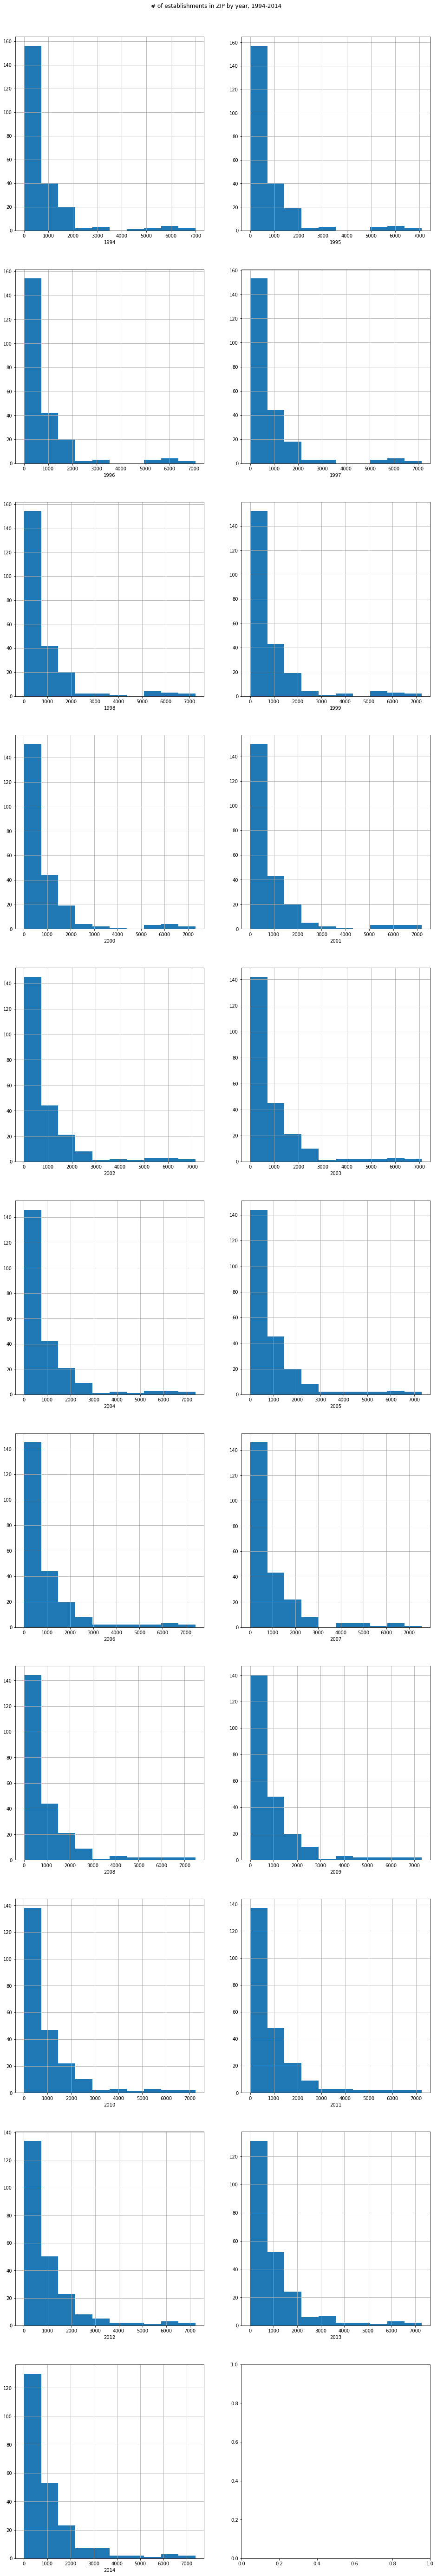

In [10]:
fig, axes = plt.subplots(11, 2, figsize=(16, 100))
axes = axes.flatten()[:21]
fig.suptitle("# of establishments in ZIP by year, 1994-2014", y=.89)
for ax, year in zip(axes, sorted(final_filtered["year"].unique())):
    final_filtered[final_filtered["year"] == year]["est"].hist(ax=ax)
    ax.set_xlabel(year)

## Caption: We don't see much but at least we validate the data is clean

## TASKS:
    
    1. get and prep your data.

In [11]:
# see above for beginning

In [12]:
# i'd say 1 under par
zip_year_matrix = final_filtered.set_index(["zip", "year"])["est"]\
                                .sort_index()\
                                .as_matrix()\
                                .reshape(230, 21)

In [13]:
# just to confirm
# if i think about reshaping too much it scares me
sorted_thing = final_filtered.set_index(["zip", "year"])["est"].sort_index()
zips = sorted_thing.index.levels[0]
for i, z in enumerate(zips):
    assert (sorted_thing.loc[z] == zip_year_matrix[i]).all()

In [14]:
means, stds = zip_year_matrix.mean(axis=1), zip_year_matrix.std(axis=1)
zip_year_standardized = ((zip_year_matrix.T - means.T) / stds.T).T
epsilon = .001
assert ((zip_year_standardized.mean(axis=1) - 0) < epsilon).all()
assert ((zip_year_standardized.std(axis=1) - 1) < epsilon).all()

    2. cluster the NUMBER OF ESTABLISHMENTS time series with K-means in **a few** clusters (as discussed there is no real good, sound way to decide what a good number is here. try a few options, keeping in mind a few is more than a couple, but i recommand you stay within the single digit numbers)
    

In [15]:
def sse(matrix, clusters):
    score = 0
    for m, l in zip(matrix, clusters.labels_):
        center = clusters.cluster_centers_[l]
        score = score + np.sqrt(np.sum((m - center)**2))
    return score

Looking at this this elbow plot, I choose 7. 8 might also be a reasonable size


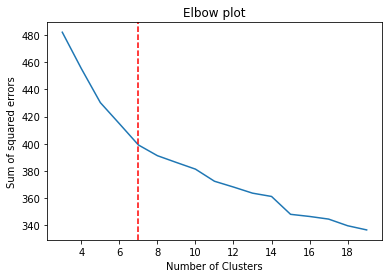

In [16]:
sse_scores = []
for n_clusters in range(3, 20):
    clusters = KMeans(n_clusters=n_clusters, random_state=42).fit(zip_year_standardized)
    sse_scores.append(sse(zip_year_standardized, clusters))

plt.figure()
plt.plot(range(3, 20), sse_scores)
plt.xlabel("Number of Clusters")
plt.ylabel("Sum of squared errors")
plt.title("Elbow plot")
plt.axvline(7, c="r", linestyle='dashed')
print "Looking at this this elbow plot, I choose 7. 8 might also be a reasonable size"

    3. plot the cluster centers (if you used K means those are the means of the clusters). you can plot for example the cluster centers overlayed on each time series (using the alpha channel to control the opacity in the plot may be helpful here).
    

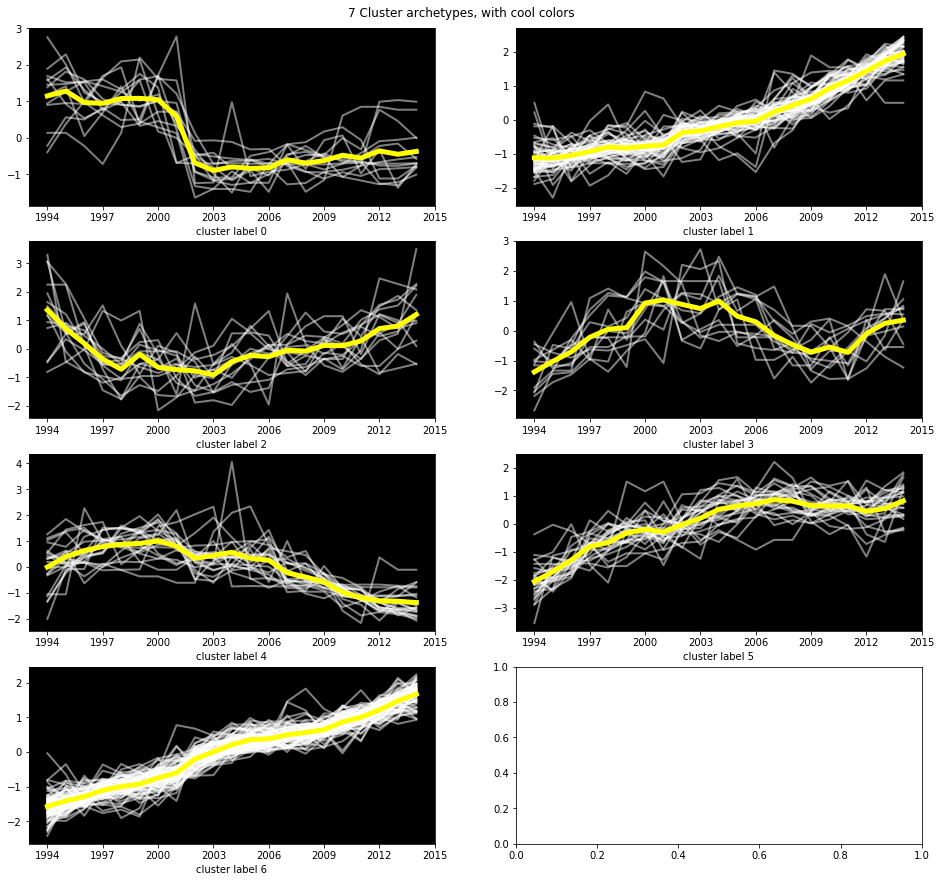

In [17]:
final_kmeans = KMeans(n_clusters=7, random_state=42).fit(zip_year_standardized)
fig, axes = plt.subplots(4, 2, figsize=(16, 15))
axes = axes.flatten()[:7]
fig.suptitle("7 Cluster archetypes, with cool colors", y=.9)
for ts, l in zip(zip_year_standardized, final_kmeans.labels_):
    ax = axes[l]
    ax.plot(range(1994, 2015), ts, c='white', alpha=.5, linewidth=2)
    
for i, (ax, cluster) in enumerate(zip(axes, final_kmeans.cluster_centers_)):
    ax.plot(range(1994, 2015), cluster, linewidth=5, c='yellow')
    ax.set_xticks(range(1994, 2016, 3))
    ax.set_xlabel("cluster label {}".format(i))
    ax.set_facecolor((0, 0, 0))

    

6    88
1    57
5    25
4    21
2    14
0    13
3    12
dtype: int64

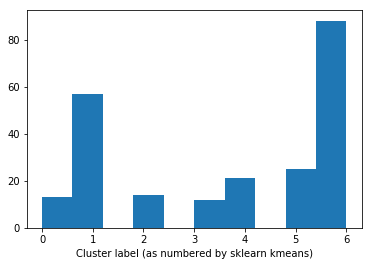

In [18]:
s = pd.Series(final_kmeans.labels_)
ax = s.hist(grid=False)
ax.set_xlabel("Cluster label (as numbered by sklearn kmeans)")
s.value_counts()

### Caption: 7 timeseries archetypes, plotted with the elements of their cluster, and bar chart of counts of labels.

From the cluster archetypes, we see:
- Cluster label 0 experienced a significant dropoff between 2000-2003.
- Cluster label 1 experienced steady exponential growth.
- Cluster label 2 saw decreases 1994 - 2003 then growth 2003-on
- Cluster label 3 saw growth until 2003, then decreases until 2010, then further growth. Looks periodic.
- Cluster label 4 grew until about 2001 then decreased.
- Cluster label 5 saw growth until 2008 then peaked.
- Cluster label 6 saw steady linear growth

From the histogram can see that labels 1 and 6 (steady linear / exponential growth) covers most zipcodes (in terms of number of zipcodes). The others had < 25 zipcodes, but all had more than 10 zipcodes.

    4. Use another clustering algorithm (of your choice)

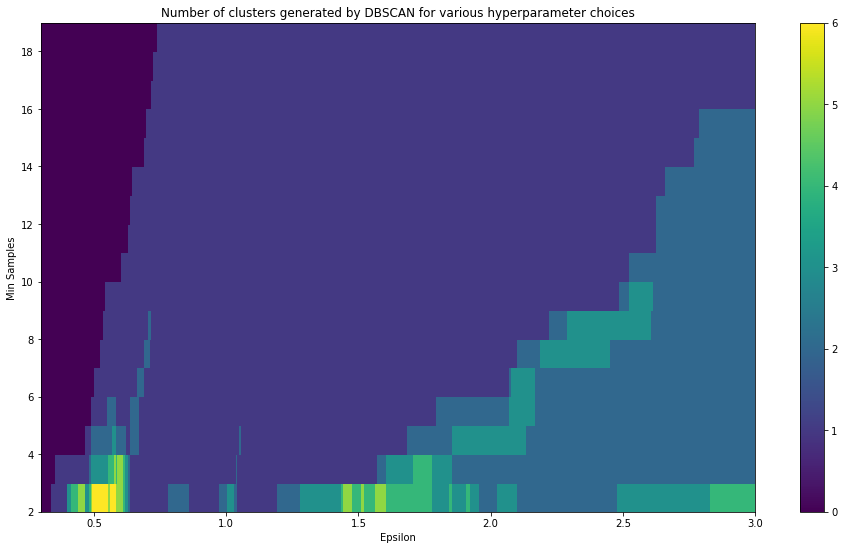

In [19]:
# PEP8 remark: i include this import here to indicate my choice
from sklearn.cluster import DBSCAN

X, Y = np.meshgrid(np.linspace(.3, 3, 400), np.arange(2, 20, 1))
n_labels = []
proportions_of_labels = []
for epsilon in X[0]:
    n_labels_at_epsilon = []
    proportion_at_epsilon = []
    for min_samples in Y[:, 0]:
        clustered = DBSCAN(eps=epsilon, min_samples=min_samples).fit(zip_year_standardized)
        non_negatives = [c for c in clustered.labels_ if c != -1]
        negatives = [c for c in clustered.labels_ if c == -1]
        n_labels_at_epsilon.append(len(Counter(non_negatives)))
        proportion_at_epsilon.append(float(len(non_negatives)) / (float(len(non_negatives)) + float(len(negatives)))
) 
    
    n_labels.append(n_labels_at_epsilon)
    proportions_of_labels.append(proportion_at_epsilon)
n_labels = np.array(n_labels).T
proportions_of_labels = np.array(proportions_of_labels).T
plt.figure(figsize=(16, 9))
plt.pcolormesh(X, Y, (n_labels))
plt.colorbar()
plt.xlabel("Epsilon")
plt.ylabel("Min Samples")
plt.title("Number of clusters generated by DBSCAN for various hyperparameter choices")

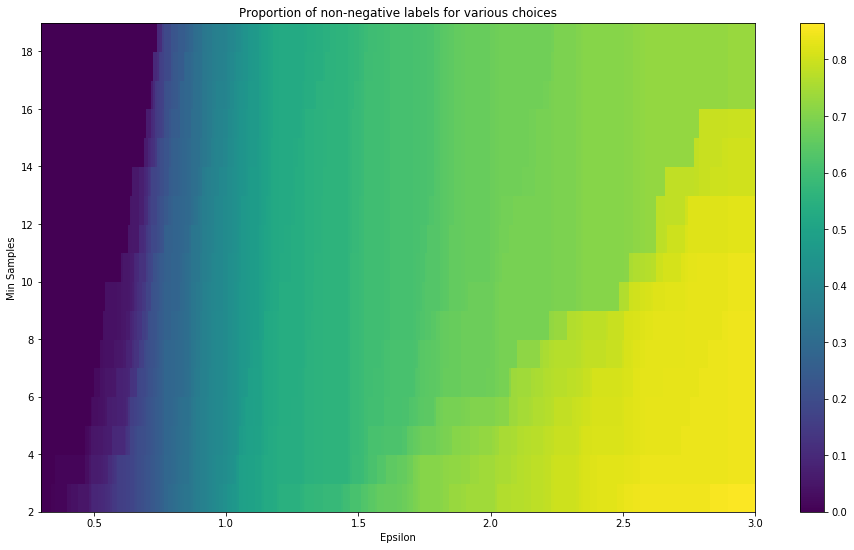

In [20]:
plt.figure(figsize=(16, 9))
plt.pcolormesh(X, Y, (proportions_of_labels))
plt.colorbar()
plt.xlabel("Epsilon")
plt.ylabel("Min Samples")
plt.title("Proportion of non-negative labels for various choices")

### Caption for above two figures: This is purely experimentation, I have never played with DBSCAN and I don't know a good way to evaluate DBSCAN hyperparameters.

### Figure 1. Makes sense - if we allow for a small number of points to constitute a cluster and have a small epsilon, then we have many clusters.  However, the proportion of points that actually get clustered is small, so these clusters is not particularly useful.

### Figure 2. Behaves similarly - the proportion of clustered points increases as we allow for smaller legitimate clusters, and as we increase our epsilon range. However, we never get much above .85, which is concerning.

### I would also want to plot the variance in the size of the clusters.

### [This Link](https://www.naftaliharris.com/blog/visualizing-dbscan-clustering/) was cool and helpful

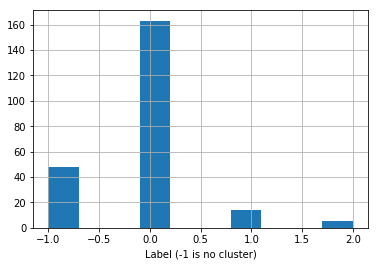

In [21]:
## Given the above discussion, espilon=2.5 and min_samples=8 seems like a sweet spot.

final_dbscan = DBSCAN(eps=2.5, min_samples=8).fit(zip_year_standardized)
ax = pd.Series(final_dbscan.labels_).hist()
ax.set_xlabel("Label (-1 is no cluster)")

### In the above histogram we can see that almost everything falls into cluster 0. Exploration uncovered this was the case with most parameter choices. So DBScan is not doing a good job of finding clusters here.

    5. overlay your data on a NYC map: you can use shapefiles for the zip codes and different colors for different clusters
    

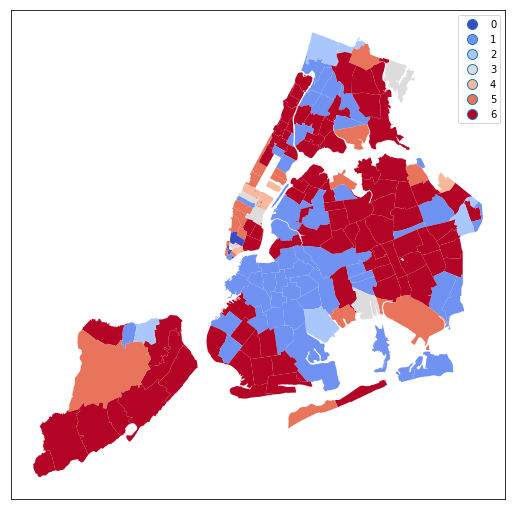

In [23]:
final_zips = final_filtered.sort_values("zip").zip.unique()
final_kmeans_labels = final_kmeans.labels_
final_dbscan_labels = final_dbscan.labels_
to_merge = pd.DataFrame({"ZIPCODE": final_zips, "kmeans": final_kmeans_labels, "dbscan": final_dbscan_labels})
zips_with_labels = zipcodes.merge(to_merge, on="ZIPCODE").drop_duplicates(subset=["ZIPCODE"])
ax = zips_with_labels.plot('kmeans', cmap='coolwarm', figsize=(16, 9), legend=True,categorical=True)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

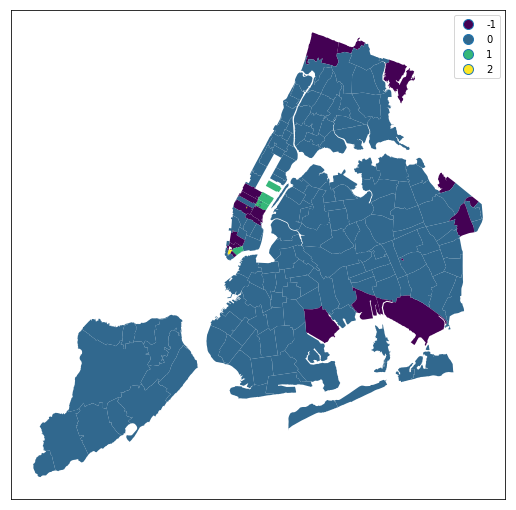

In [24]:
ax = zips_with_labels.plot('dbscan', figsize=(16, 9), legend=True, categorical=True, cmap='viridis')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

    6. Compare the results of the 2 algorithms

### K-means creates 2 "main" clusters and then 5 smaller clusters. Most of the city falls into one of these, midtown /  lower manhattan zips fall into the smaller clusters. DBScan has 3 clusters - 1 "main" cluster, and two other tiny clusters. Midtown / lower manhattan zips are considered "outliers". Perhaps "outliers" is a more accurate characterization rather than clustering them together.

### Outside of lower manhattan, KMeans consistently clusters the NW corner of the Bronx, a SE corner of Brooklyn, and something on the North Shore of Staten Island. On the other hand, DBScan considers Staten Island part of the "main" cluster, while the Brooklyn / Bronx zipcodes are both considered outliers.

    7. attempt an interpretation. this is dangerous ground: clustering is an exploratory tool so you do not want to jump to conclusions because you see some clusters! but seeing structure in your data can inform your next moves as an investigator. 
    

Let's first look at KMeans. 

- Label 0
  - This label experienced a significant dropoff between 2000-2003.
  - This label, on the map, is lower manhattan, near the world trade center. This is probably zips that were impacted by 9/11, in 2001.

- Cluster label 1 experienced steady exponential growth.
  - Greenpoint, LIC, much of central brooklyn, Marble Hill / Bronx...
  - As compared to label 6 (linear growth), perhaps these areas grew more quickly. 
  
- Cluster label 2 saw decreases 1994 - 2003 then growth 2003-on
  - This label includes several far-away places, such as Staten Island's North Shore, NW Bronx, SE Brooklyn. 

- Cluster label 3 saw growth until 2003, then decreases until 2010, then further growth. Looks periodic.
  - I don't take much stock in this cluster. Murray Hill, City Island, and East Brooklyn?
  - Or, at the very least ,further investigation would be required.
- Cluster label 4 grew until about 2001 then decreased.
  - This label is also a bit spurious. Maybe these areas have been affected by changing commuter patterns? What's up with the one in far-away brooklyn?
- Cluster label 5 saw growth until 2008 then peaked.
  - Again, a potentially spurious cluster. West manhattan (chelsea, hell's kitchen) maybe finished peak gentrifying and building conversion around this time?
- Cluster label 6 saw steady linear growth
  - Probably another standard / control group - this and label 1 cover most of the city.

From the histogram can see that labels 1 and 6 (steady linear / exponential growth) covers most zipcodes (in terms of number of zipcodes). The others had < 25 zipcodes, but all had more than 10 zipcodes.

Then, as mentioned above, DBScan gives us a good sense of "mainstream" vs. "outlier" zipcodes. The smaller clusters in DBScan map to the outliers in KMeans.

#### As a final conclusion, I think each of the small clusters KMeans generated warrants more research in those specific areas. Did zoning change? What else may have changed? The 9/11 cluster indicates we are capturing potentially anomalous / key events. 

#### Likewise, DBScan validates that our "mainstream" group is most of the city, and we're left with a few "outlier" zipcodes that experienced strange phenomena. These "outlier" (and the 2 tiny clusters) zips map to the smaller clusters in KMeans, further validating the need for additional, area-specific research.

---
End of my analysis
---
---
---
---
---
---
---
---
---
---
---


### The map of the clusters may look something like this

In [ ]:
...

### Figure 3: 
cloropleth of  cluster centers for 5 k-means clusters of business patterns (number of businesses) at the zipcode level for NYC zipcodes: each color indicates a cluster. The business pattern time series are plotted at the top.

### or maybe like this, depending on which algorithm you use, and how you proceed to preprocess your data and how you cluster it. There is no one correct answer, but general trends should be retrieved.

In [ ]:
...

### Figure 9: 
As figures 3, 5, 7 for hierarchical agglomerative clustering in 7 clusters, with smoothed time series

### And if you use hierarchical clustering and make a dandrogram it may look like this:

In [ ]:
from PIL import Image
Image.open("dandrogram.png")

Points: 10